In [1]:
import os
import sys

device = "cuda:1"

# Setup: and Selenium chrome driver to PATH and set MINIWOB_BASE_URL env variable to the directory with HTML task files

In [2]:
from miniwob.environment import MiniWoBEnvironment
from miniwob.action import  MiniWoBCoordClick
from miniwob.screenshot import pil_to_numpy_array

task_name = 'click-button'
base_url = os.environ.get('MINIWOB_BASE_URL')
print('BASE URL:', base_url)

BASE URL: file:///mnt/akostin/home/akostin/prjs/miniwob-plusplus/html/


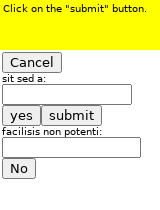

In [3]:
env = MiniWoBEnvironment(task_name, seeds=[1], num_instances=1, base_url=base_url, headless=True)
state = env.reset(record_screenshots=True, seeds=[1123])
state[0].screenshot

In [4]:
env.close()

In [5]:
import torch
from transformers import BertTokenizer
X_MAX, Y_MAX = 160, 210
DOM_TEXT_MAX_TOKENS = 8
GOAL_MAX_TOKENS = 16
DOM_MAX_EDGES = 20
DOM_MAX_VERTICES = 20


class DOMVertex():
    def __init__(self, dom_element, i, text_tokenizer, tokenization_kwargs):
        self.id = i
        self.tag = dom_element.tag
        self.cx, self.cy, self.width, self.height = (dom_element.left + dom_element.width/2)/X_MAX, \
                                                    (dom_element.top + dom_element.height/2)/Y_MAX, \
                                                    dom_element.width/X_MAX, dom_element.height/Y_MAX
        self.focused = dom_element.focused
        self.tampered = dom_element.tampered
        text = dom_element.text if dom_element.text else ""
        self.text_tokens = text_tokenizer(text, **tokenization_kwargs)['input_ids']
    
    def get_feat_vector(self):
        simple_feats = torch.tensor([self.cx, self.cy, self.width, self.height, self.focused, self.tampered],\
                                    dtype=torch.float32)
        return simple_feats, self.text_tokens


class DOMTree():
    def __init__(self, text_tokenizer=None, tokenization_kwargs=dict()):
        self.i=0
        if text_tokenizer:
            self.text_tokenizer = text_tokenizer
            self.tokenization_kwargs = tokenization_kwargs
        else:
            self.text_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
            self.tokenization_kwargs ={"padding": 'max_length',
                                       "max_length": DOM_TEXT_MAX_TOKENS,
                                       "truncation": True,
                                       "return_tensors": "pt",}
        self.vertices = list()
        self.fr0m = list()
        self.to = list()
    
    def build_tree(self, root_element):
        candidates = [(root_element, -1)]
        while len(candidates):
            element, parent_id = candidates.pop()
            self.vertices.append(DOMVertex(element, self.i, self.text_tokenizer, self.tokenization_kwargs))
            if parent_id>=0:
                self.fr0m.append(parent_id)
                self.to.append(self.i)
            candidates += [(child, self.i) for child in element.children]
            self.i += 1
    
    def reset(self):
        self.vertices = list()
        self.fr0m = list()
        self.to = list()
        self.i = 0
    
    def get_data(self):
        simple, text = list(), list()
        for vertex in self.vertices:
            s, t = vertex.get_feat_vector()
            simple.append(s); text.append(t)
        
        delta_e = DOM_MAX_EDGES - len(self.fr0m)
        self.fr0m += [-1 for i in range(delta_e)]
        self.to += [-1 for i in range(delta_e)]
        
        delta_v = DOM_MAX_VERTICES - len(simple)
        simple += [-torch.ones((6,), dtype=torch.float32) for i in range(delta_v)]
        text += [torch.zeros((1, DOM_TEXT_MAX_TOKENS), dtype=torch.int64) for i in range(delta_v)]
        
        return {
            "dom_from": torch.tensor(self.fr0m, dtype=torch.int64).unsqueeze(0),
            "dom_to": torch.tensor(self.to, dtype=torch.int64).unsqueeze(0),
            "dom_simple_feats": torch.stack(simple, dim=0).unsqueeze(0),
            "dom_text_tokens": torch.cat(text, dim=0).unsqueeze(0),
        }

# Gym miniwob wrapper

In [6]:
import gym
import torch

from miniwob.action import MiniWoBElementClick, MiniWoBCoordClick
from transformers import BertTokenizer, BertModel, BertConfig
import numpy as np


class MiniWobClickButtonWrapper(gym.Wrapper):
    
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        bert_model = 'bert-base-cased'
        
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.tree = DOMTree()
        
        self.observation_space = gym.spaces.Dict({"goal_state": gym.spaces.Box(0, 
                                                                              self.tokenizer.vocab_size,
                                                                               (GOAL_MAX_TOKENS, ),
                                                                              dtype=np.int64),
                                                  "img_state": gym.spaces.Box(0,
                                                                        255,
                                                                        (150, 150, 3),
                                                                        dtype=np.uint8),
                                                  "dom_simple_feats": gym.spaces.Box(-1,
                                                                                     1,
                                                                                     (DOM_MAX_VERTICES, 6),
                                                                                     dtype=np.float32),
                                                  "dom_text_tokens": gym.spaces.Box(0,
                                                                                    self.tokenizer.vocab_size,
                                                                                    (DOM_MAX_VERTICES, DOM_TEXT_MAX_TOKENS),
                                                                                    dtype=np.int64),
                                                  "dom_from": gym.spaces.Box(-1,
                                                                             DOM_MAX_VERTICES,
                                                                             (DOM_MAX_EDGES, ),
                                                                             dtype=np.int64),
                                                  "dom_to": gym.spaces.Box(-1,
                                                                           DOM_MAX_VERTICES,
                                                                           (DOM_MAX_EDGES, ),
                                                                           dtype=np.int64)})
        
        self.dom_keys = [key for key in self.observation_space if key.startswith("dom")]
        self.h, self.w = 210, 160
        self.grid_step = 10
        n_actions = int(self.h/self.grid_step+1) * int(self.w/self.grid_step+1)
        self.action_space = gym.spaces.Discrete(n_actions)
    
    def _ob_to_dom(self, ob):
        max_length = DOM_TEXT_MAX_TOKENS
        if ob is None:
            return {
                "dom_simple_feats": -torch.ones((1, DOM_MAX_VERTICES, 6), dtype=torch.float32),
                "dom_text_tokens": torch.zeros((1, DOM_MAX_VERTICES, DOM_TEXT_MAX_TOKENS), dtype=torch.int64),
                "dom_from": -torch.ones((1, DOM_MAX_EDGES), dtype=torch.int64),
                "dom_to": -torch.ones((1, DOM_MAX_EDGES), dtype=torch.int64)
            }
        else:
            self.tree.reset()
            self.tree.build_tree(ob.dom)
            return self.tree.get_data()
    
    def _ob_to_token(self, ob):
        max_length = GOAL_MAX_TOKENS
        if ob is None:
            return torch.zeros(1, max_length)
        else: 
            return self.tokenizer(ob.tokens,  
                                  padding='max_length', 
                                  max_length = max_length, truncation=True,          
                                  return_tensors="pt",
                                  is_split_into_words=True)['input_ids']
            
    def _ob_to_image(self, ob):
        if ob is None:
            return torch.zeros(1, 150, 150, 3)
        else:
            return torch.tensor(pil_to_numpy_array(ob.screenshot.resize([150, 150]))).unsqueeze(0)
        
    
    def _to_miniwob_actions(self, actions):
        
        n_x = int(self.w/self.grid_step + 1)        
        actions = actions.squeeze()
        miniwob_actions = []
        
        for i in range(self.num_instances):
            if self.instances[i].get_metadata()['done']:
                miniwob_actions.append(None)
            else:
                k = actions[i].item()
                x, y = k%n_x * self.grid_step, int(k/n_x) * self.grid_step
                miniwob_actions.append(MiniWoBCoordClick(x, y))
        return miniwob_actions

    def observation(self, obs):
        goals = torch.cat([self._ob_to_token(ob) for ob in obs], dim=0)
        imgs = torch.cat([self._ob_to_image(ob) for ob in obs], dim=0)
        doms = [self._ob_to_dom(ob) for ob in obs]
        doms_states = {key: torch.cat([dom[key] for dom in doms], dim=0) for key in self.dom_keys}
        return {'img_state': imgs, 'goal_state': goals, **doms_states}
    
    def reset(self):
        return self.observation(self.env.reset(record_screenshots=True))
    
    def step(self, actions):
        miniwob_actions = self._to_miniwob_actions(actions)
        obs, rewards, dones, infos = self.env.step(miniwob_actions)        
        obs = self.observation(obs)
        
        for instance in self.env.instances:
            if instance.get_metadata()['done']:
                instance.begin_task()
        
        return obs, torch.tensor([rewards]).T, torch.tensor([dones]).T, infos['n']


class EpisodeInfoWrapper(gym.Wrapper):
    
    def __init__(self, env, n):
        super(EpisodeInfoWrapper, self).__init__(env)
        self.episode_reward = np.zeros(n)
        self.episode_steps = np.zeros(n)
        self.n = n

    def reset(self):
        self.episode_reward = np.zeros(self.n)
        self.episode_steps = np.zeros(self.n)
        return self.env.reset()

    def step(self, actions):
        states, rewards, dones, infos = self.env.step(actions)
        
        for i, done in enumerate(dones):
            if done:
                self.episode_reward[i] = rewards[i]
                self.episode_steps[i] += 1
                infos[i]['episode'] = {'r': self.episode_reward[i], 'steps': self.episode_steps[i]}
                
        return states, rewards, dones, infos

# Bert encoder

In [7]:
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
from torch.nn import Linear
from torch.nn.functional import relu
import torch


class BertEncoder(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        bert_model = 'bert-base-cased'
        
        self.bert_encoder = BertModel.from_pretrained(bert_model)
        self.embed_dim = 768
        self.output_size = 64
        self.out_layer = nn.Linear(self.embed_dim, self.output_size)
        tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.pad_token = tokenizer.pad_token_id
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        text_tokens_embed = self.bert_encoder(input_ids.long())[0]
        with torch.no_grad():
            embeds = relu(self.out_layer(text_tokens_embed))
        
        pad_mask = torch.where(input_ids.long() == self.pad_token, True, False)
        return embeds, pad_mask


class DOMBert(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        bert_model = 'bert-base-cased'
        
        self.bert_encoder = BertModel.from_pretrained(bert_model)
        self.embed_dim = 768
        self.output_size = 64 - 6
        self.out_layer = nn.Linear(self.embed_dim, self.output_size)
    
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        with torch.no_grad():
            text_tokens_embed = self.bert_encoder(input_ids.long())[1]
        out = relu(self.out_layer(text_tokens_embed))
        return out

# DOM Encoder

In [8]:
import dgl
from dgl.nn import GraphConv
import torch
from torch.nn import ModuleList, Parameter, TransformerEncoderLayer, TransformerEncoder
from torch.nn.functional import relu, softmax


UNDIRECTED = True
SELF_LOOP = True
bert_model = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
pad_token_id = tokenizer.pad_token_id


class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        in_feats, h_dim, n_layers = 64, 64, 1
        in_layer = GraphConv(in_feats, h_dim)
        self.layers = ModuleList([in_layer, *[GraphConv(h_dim, h_dim) for i in range(n_layers-1)]])
    
    def forward(self, graph, features):
        out = features
        for layer in self.layers:
            out = layer(graph, out)
            out = relu(out)
        return graph


class DOMNET(nn.Module):
    def __init__(self):
        super(DOMNET, self).__init__()
        self.gcn = GCN()
        self.bert = DOMBert()
    
    def forward(self, input):
        graphs = list()
        for fr0m, to, simple_feats, text_tokens in zip(input["dom_from"], input["dom_to"],\
                                                       input["dom_simple_feats"], input["dom_text_tokens"]):
            
            edge_mask = fr0m!=-1
            vertex_mask = torch.all(simple_feats!=-torch.ones_like(simple_feats[0]), dim=1)
            fr0m = fr0m[edge_mask]
            to = to[edge_mask]
            simple_feats = simple_feats[vertex_mask]
            text_tokens = text_tokens[vertex_mask]
            
            text_embed = self.bert(text_tokens)
            vertices_embeds = torch.cat([text_embed, simple_feats], dim=-1)
            
            graph = dgl.graph((fr0m.long(), to.long()))
            graph.ndata['vertex_embed'] = vertices_embeds
            if UNDIRECTED:
                graph = dgl.add_reverse_edges(graph)
            if SELF_LOOP:
                graph = dgl.add_self_loop(graph)
            graphs.append(graph)
        
        batch_graph = dgl.batch(graphs)
        batch_graph = self.gcn(batch_graph, batch_graph.ndata['vertex_embed'])
        
        graphs = [graph.ndata["vertex_embed"] for graph in dgl.unbatch(batch_graph)]
        embeds, mask = self.collate_fn(graphs)
        return embeds, mask
    
    @staticmethod
    def collate_fn(tensor_list):
        vec_dim = tensor_list[0].shape[1]
        max_n_vec = max([t.shape[0] for t in tensor_list])
        bs = len(tensor_list)

        pad_mask = torch.zeros((bs, max_n_vec), dtype=torch.bool).to(device)
        pad_vector = torch.zeros((1, vec_dim)).to(device)

        for i in range(bs):
            delta = max_n_vec - tensor_list[i].shape[0]
            pad = torch.repeat_interleave(pad_vector, delta, dim=0)
            tensor_list[i] = torch.cat([tensor_list[i], pad], dim=0)
            pad_mask[i, -delta:] = True

        return torch.stack(tensor_list, dim=1), pad_mask


class DOMGoalTransformer(nn.Module):
    def __init__(self):
        super(DOMGoalTransformer, self).__init__()
        self.inp_dim = 64
        self.output_size = self.inp_dim
        
        self.embed_token = nn.Parameter(torch.empty(1, 1, self.inp_dim))
        nn.init.uniform_(self.embed_token, -0.1, 0.1)
        
        encoder_layer = TransformerEncoderLayer(64, 4, dim_feedforward=64, norm_first=True)
        self.encoder = TransformerEncoder(encoder_layer, 1)
    
    def forward(self, inp, mask):
        mask = torch.cat([torch.zeros_like(mask[:, :1], dtype=torch.bool), mask], dim=1)
        inp = torch.cat([self.embed_token.repeat_interleave(inp.shape[1], dim=1), inp], dim=0)
        out = self.encoder(inp, src_key_padding_mask=mask)
        return out[0]

"""
class DOMGoalAttention(nn.Module):
    def __init__(self):
        super(DOMGoalAttention, self).__init__()
    def forward(self, input):
        vertices_embed, goal_embed = input[1:DOM_MAX_VERTICES], input[-GOAL_MAX_TOKENS:]
        # vertices_embed.shape = (DOM_MAX_VERTICES, batch, dim)
        # goal_embed.shape = (GOAL_MAX_TOKENS, batch, dim)
        vertices_embed = vertices_embed.permute([1,0,2])
        goal_embed = goal_embed.permute([1, 2, 0])
        attn = softmax(torch.matmul(vertices_embed, goal_embed))
        return attn
"""

class Encoder(nn.Module):
    def __init__(self, img, dom=DOMNET(), goal=BertEncoder(), tf=DOMGoalTransformer()):
        super(Encoder, self).__init__()
        self.img_encoder = img
        self.dom_net = dom
        self.goal_bert = goal
        self.tf = tf
        self.output_size = self.img_encoder.output_size + 64
    
    def forward(self, input):
        dom_embeds, dom_mask = self.dom_net(input)
        goal_embeds, goal_mask = self.goal_bert(input["goal_state"])
        dom_goal_embeds = torch.cat([dom_embeds, goal_embeds.permute([1, 0, 2])], dim=0)
        dom_goal_mask = torch.cat([dom_mask, goal_mask], dim=1)
        tf_out = self.tf(dom_goal_embeds, dom_goal_mask)
        
        img_out = self.img_encoder(input["img_state"])
        
        out = torch.cat([tf_out, img_out], dim=-1)
        return out

Using backend: pytorch
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.

# Train agent

In [9]:
import numpy as np
from rllr.env.vec_wrappers import make_vec_envs
from stable_baselines3.common.vec_env import DummyVecEnv


def get_envs(n, **kwargs):
    env = MiniWoBEnvironment(task_name, seeds=range(n), num_instances=n, base_url=base_url, **kwargs)
    env = MiniWobClickButtonWrapper(env)
    return EpisodeInfoWrapper(env, n)

In [10]:
n_instances = 8
envs = get_envs(n_instances, headless=True)

In [11]:
from rllr.models.encoders import GoalStateEncoder, SimpleCNN

conf = {
    "n_channels": [32, 64, 64],
    "kernel_sizes": [4, 4, 3],
    "strides": [4, 2, 1],
    "hidden_layers_sizes": [64]
}

img = SimpleCNN(grid_size=150, conf=conf)
encoder = Encoder(img)

In [12]:
from rllr.algo import PPO
from rllr.models.ppo import ActorCriticNetwork

hidden_size = 32
policy = ActorCriticNetwork(envs.action_space, encoder, encoder, hidden_size, hidden_size)

agent_conf = {
        "clip_param": 0.2,
        "ppo_epoch": 4,
        "num_mini_batch": 4,
        "value_loss_coef": 0.5,
        "entropy_coef": 0.01,
        "lr": 0.001,
        "eps": 1e-5,
        "max_grad_norm": 0.5,
}


agent = PPO(policy, **agent_conf)
agent.to(device)

In [13]:
from rllr.utils.training import train_ppo

train_conf = {
    "agent.lr": 0.001,
    "agent.device": device,
    "agent.gamma": 0.99,
    "agent.gae_lambda": 0.95,
    "training.n_env_steps": 500000,
    "training.n_steps": 50,
    "training.n_processes": n_instances,
    "training.verbose": 1,
    "outputs.path": "miniwob_cnn_gcn.p"
}

In [14]:
print("starting training")

starting training


In [16]:
try:
    train_ppo(envs, agent, train_conf)
except:
    pass

train_ppo(envs, agent, train_conf)


  0%|                                                                                                                                                                                                           | 0/625 [00:00<?, ?it/s]

dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([0, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([0, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 6

dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8,


  0%|▎                                                                                                                                                                                             | 1/625 [13:38<141:56:27, 818.89s/it]

dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([12, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([0, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([0, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([10, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 64])
goal:  torch.Size([16, 8, 64])
dom:  torch.Size([11, 8, 6

  0%|▎                                                                                                                                                                                             | 1/625 [14:45<153:30:57, 885.67s/it]


KeyboardInterrupt: 

In [ ]:
envs.close()